# Titanic - Machine Learning from Disaster


This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

# The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
%matplotlib inline


In [2]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.shape

(891, 12)

# Производим чистку данных

In [4]:
# Удаляем не информативные признаки, кроме "PassengerId", так как данная колонка потребуется для выгрузки данных
train_data.drop(['Name', 'Ticket', 'Embarked', 'Cabin'], axis=1, inplace=True)

In [5]:
train_data['Sex'] = train_data['Sex'].apply(lambda x: 0 if x == 'male' else 1)
# Переводим колонку "Пол" в номинативный формат

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,0,22.0,1,0,7.2500
1,2,1,1,1,38.0,1,0,71.2833
2,3,1,3,1,26.0,0,0,7.9250
3,4,1,1,1,35.0,1,0,53.1000
4,5,0,3,0,35.0,0,0,8.0500


In [7]:
train_data.isna().sum()
# Проверяем количество пустых значений в каждом столбце

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
dtype: int64

In [8]:
train_data = train_data.dropna(subset=['Age'])
# Удаляем строки где содержатся пустые значения в колонке Возраст


In [9]:
test_data = pd.read_csv("test.csv")

In [10]:
test_data.drop(['Name', 'Ticket', 'Embarked', 'Cabin'], axis=1, inplace=True)
test_data['Sex'] = test_data['Sex'].apply(lambda x: 0 if x == 'male' else 1)

In [11]:
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,0,34.5,0,0,7.8292
1,893,3,1,47.0,1,0,7.0000
2,894,2,0,62.0,0,0,9.6875
3,895,3,0,27.0,0,0,8.6625
4,896,3,1,22.0,1,1,12.2875


In [12]:
test_data.isna().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
dtype: int64

Для данных, по которым необходлимо сделать прогноз, мы уже не будем удалять строки, поэтому мы заполним отсутствующие значения медианным значением по столбцу "Fare" (во избежание влияния отбросов) и средним для столбца "Age".

In [13]:
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].mean())
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())

# Выявление основных независимых переменных


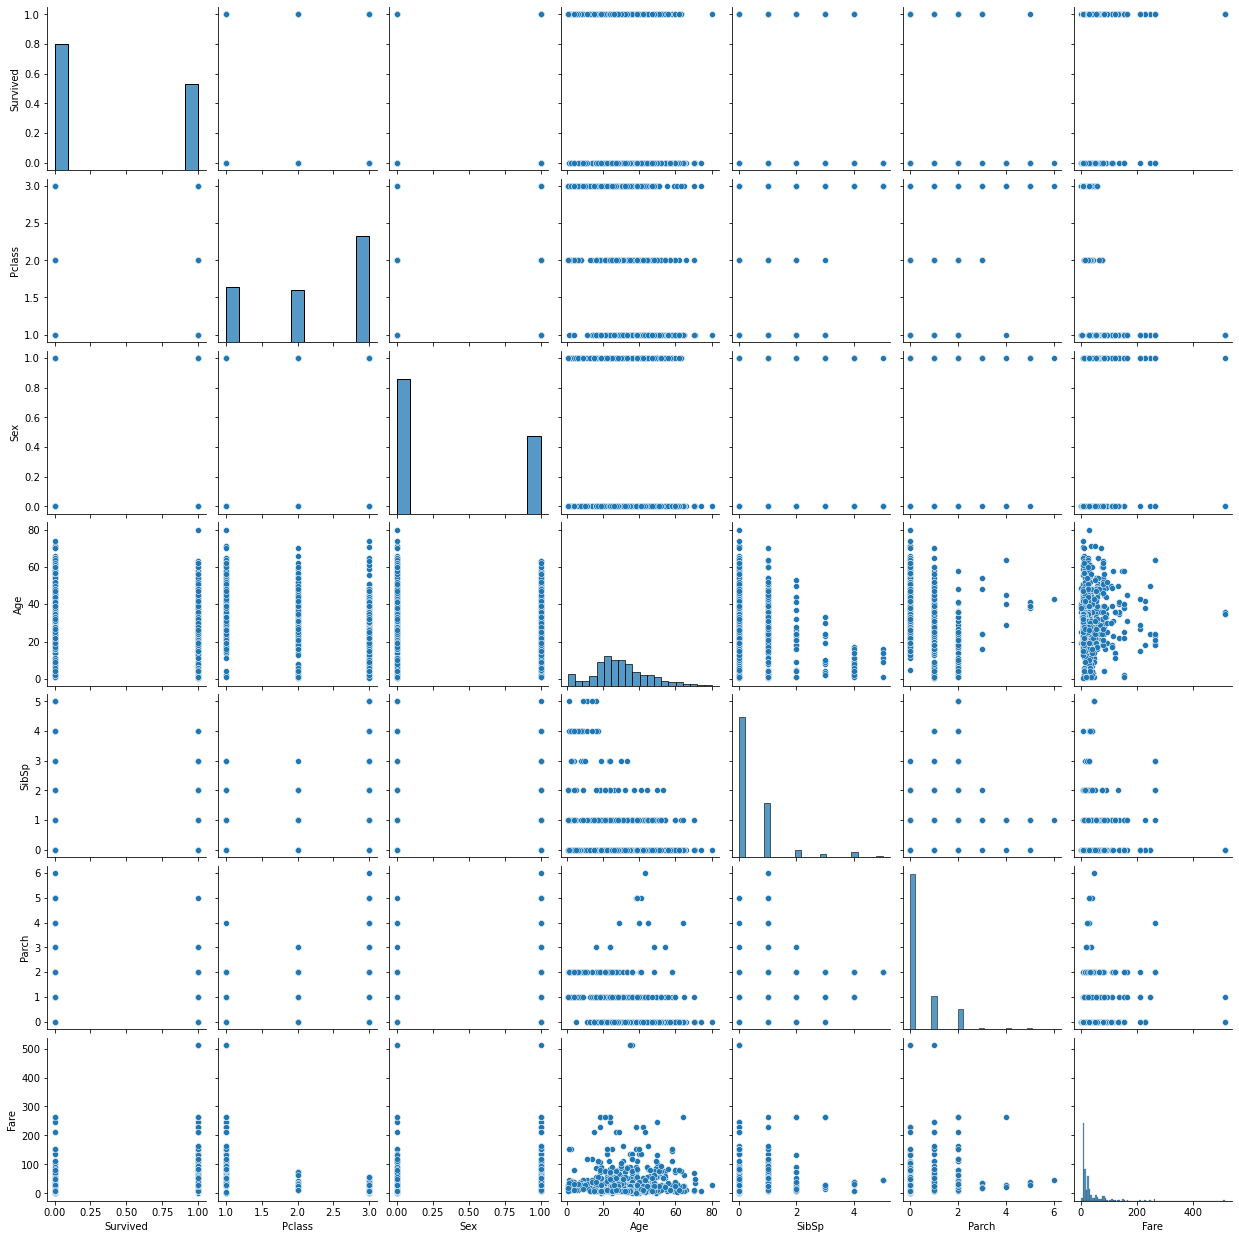

In [14]:
sns.pairplot(train_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']])

Пэйрплот выглядит неинформативным ввиду дискретности и номинативности переменных, однако, можем проверить корреляцию переменных с помощью функции .corr()

In [15]:
train_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.359653,0.538826,-0.077221,-0.017358,0.093317,0.268189
Pclass,-0.359653,1.000000,-0.155460,-0.369226,0.067247,0.025683,-0.554182
Sex,0.538826,-0.155460,1.000000,-0.093254,0.103950,0.246972,0.184994
Age,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.017358,0.067247,0.103950,-0.308247,1.000000,0.383820,0.138329
Parch,0.093317,0.025683,0.246972,-0.189119,0.383820,1.000000,0.205119
Fare,0.268189,-0.554182,0.184994,0.096067,0.138329,0.205119,1.000000


<AxesSubplot:>

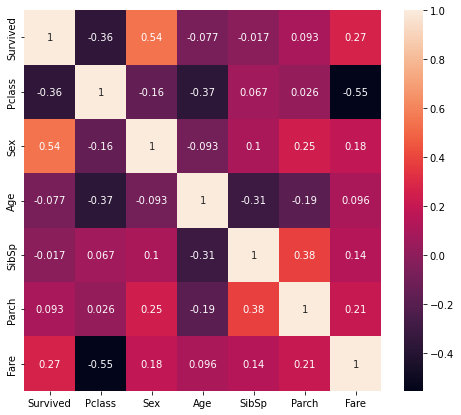

In [16]:
plt.figure(figsize=(8,7))
sns.heatmap(train_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), annot=True)

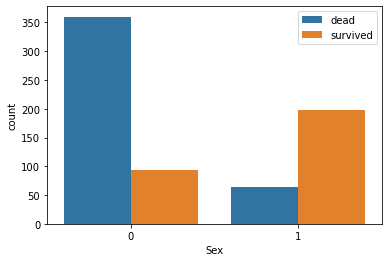

In [17]:
sns.countplot(data=train_data, x="Sex", hue="Survived")
plt.legend(labels = ['dead','survived'])

In [18]:
women = train_data.loc[train_data.Sex == 1]["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", round(rate_women*100, 2))


% of women who survived: 75.48


In [19]:
men = train_data.loc[train_data.Sex == 0]["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", round(rate_men*100,2))

% of men who survived: 20.53


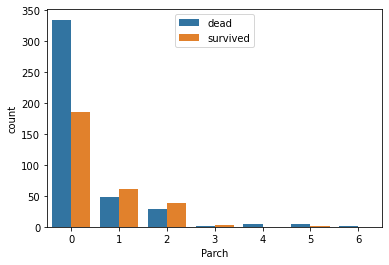

In [20]:
sns.countplot(data=train_data, x="Parch", hue="Survived")
plt.legend(labels = ['dead','survived'])

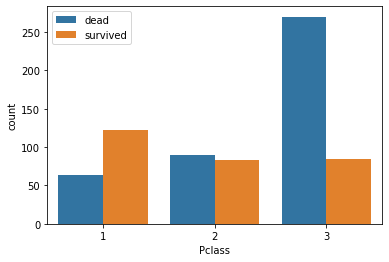

In [21]:
sns.countplot(data=train_data, x="Pclass", hue="Survived")
plt.legend(labels = ['dead','survived'])

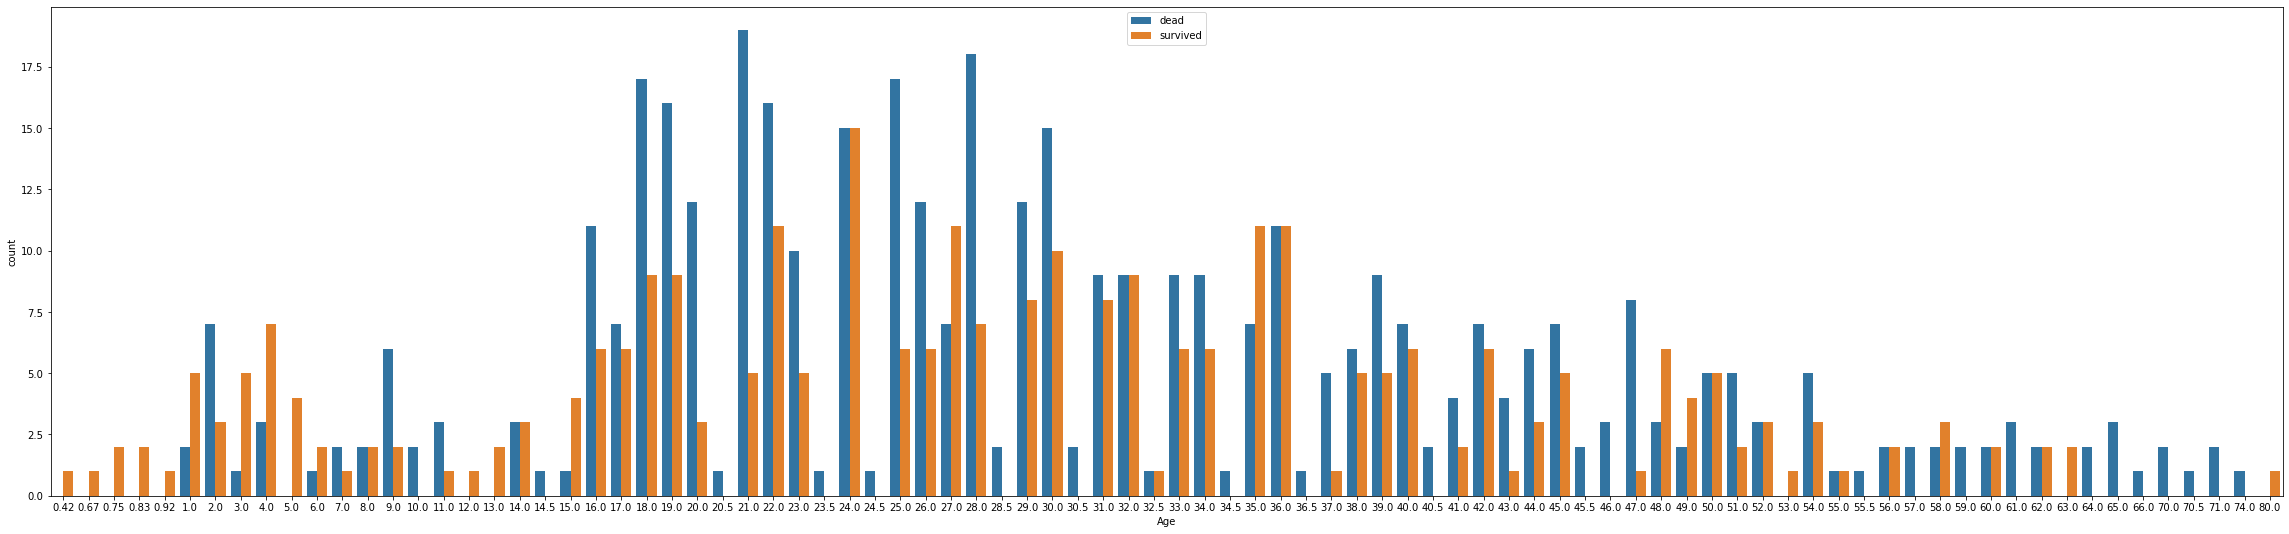

In [22]:
plt.figure(figsize=(40, 9)) 
sns.countplot(data=train_data, x="Age", hue='Survived')
plt.legend(labels = ['dead','survived'])


Наибольшая корреляция с переменной "Survived" наблюдается у переменных "Pclass", "Sex", "Fare". Однако, у переменной "Fare" наблюдается сильная корреляция с иными переменными, поэтому использование данной переменной в нашем анализе является нежелательным.

Переменные "SibSp" и "Parch" примерно одинаковым образом коррелируют с целевой переменной (хоть и в малой степени), однако, коррелируют между собой, поэтому выбираем одну из двух переменных ("Parch").

Переменная "Age" избирается ввиду визуальной корреляции переменных (явно выраженная выживаемость детей до 9 лет, большая вероятность смерти для пассажиров от 16 до 30 лет)

In [23]:
y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})


In [24]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Указанная модель предсказывает вероятность выживания в аналогичных обстоятельствах с вероятностью 78,71% (https://www.kaggle.com/competitions/titanic)